C:\Users\Aayush\AppData\Local\Temp\ipykernel_12088\102243372.py:124: DtypeWarning: Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding='latin-1')
C:\Users\Aayush\AppData\Local\Temp\ipykernel_12088\102243372.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attack_type_df['natlty1'].fillna('Unknown', inplace=True)


Model trained with accuracy: 0.8789301755818701
Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.76      0.79       483
           2       0.85      0.89      0.87      1634
           3       0.94      0.97      0.96      1772
           6       0.79      0.63      0.70       469
           7       0.81      0.79      0.80       193
           9       0.87      0.89      0.88       347

    accuracy                           0.88      4898
   macro avg       0.85      0.82      0.83      4898
weighted avg       0.88      0.88      0.88      4898



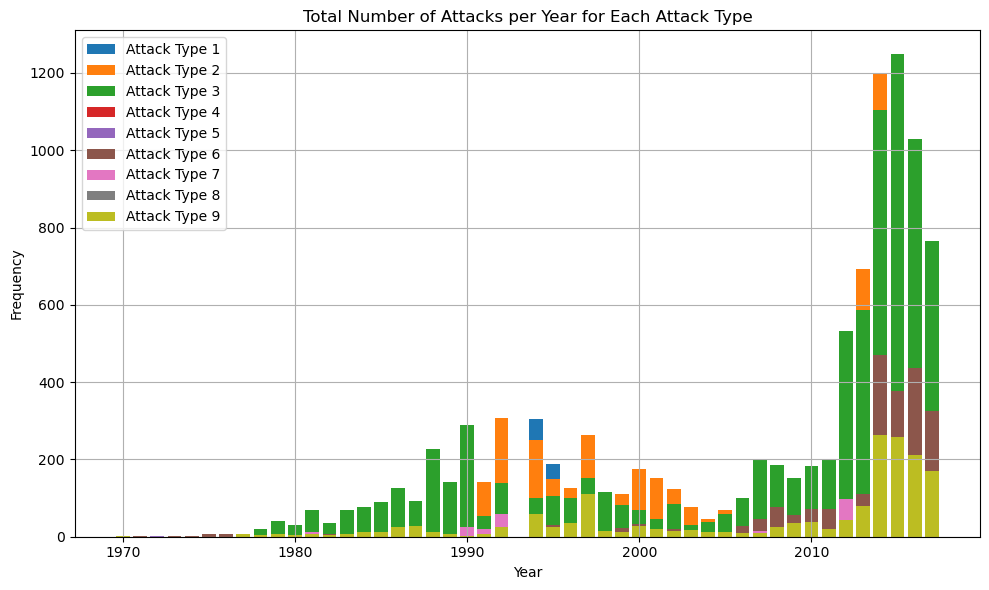

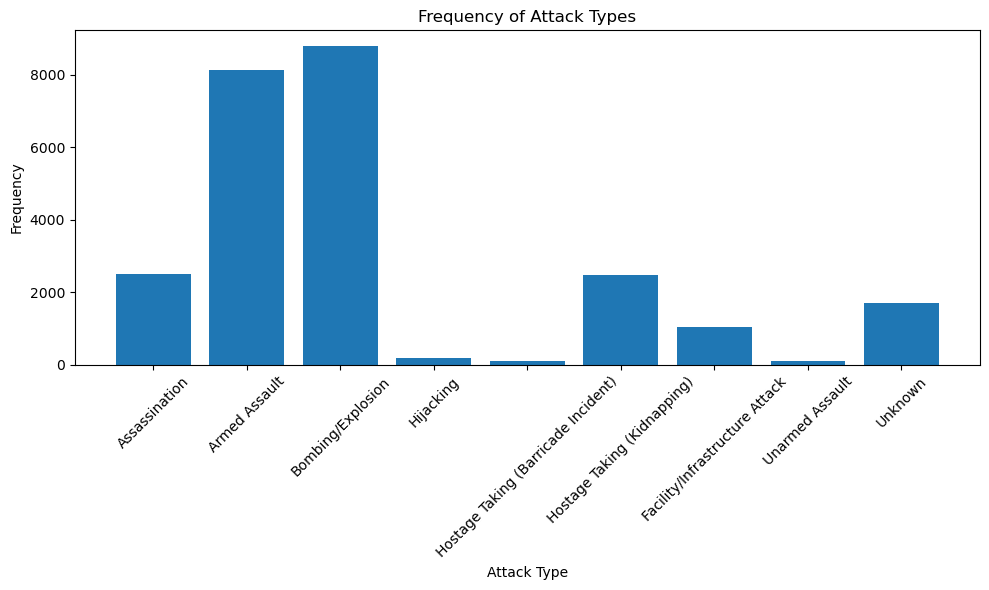

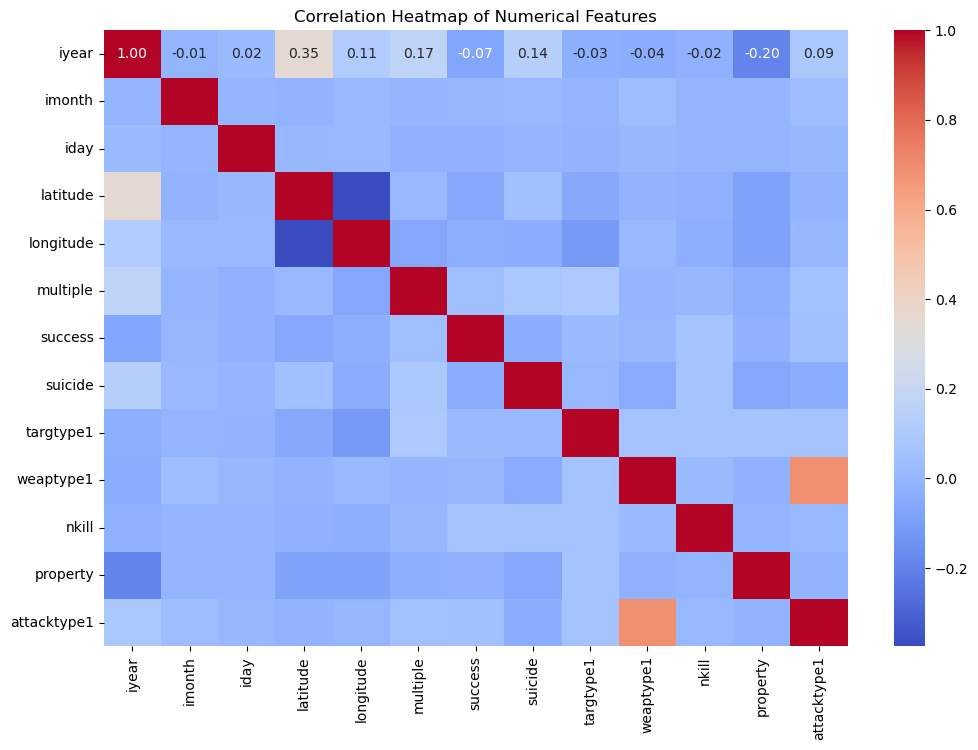

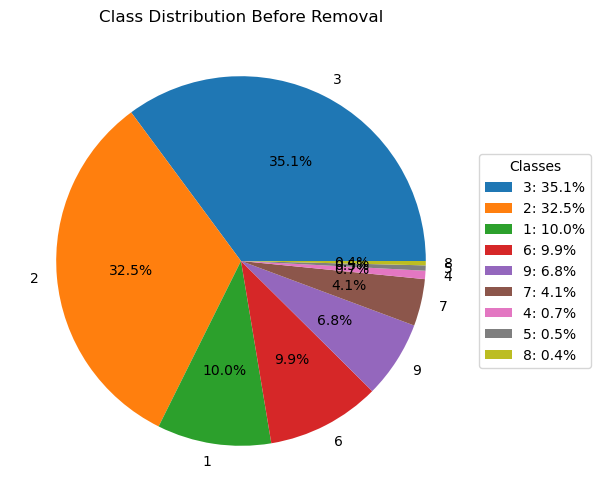

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample

def preprocess_data(df):
    # Filtering only African Countries
    african_countries = [
        "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", 
        "Cameroon", "Central African Republic", "Chad", "Comoros", "Democratic Republic of the Congo", 
        "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon", 
        "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Ivory Coast", "Kenya", "Lesotho", "Liberia", 
        "Libya", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", 
        "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "São Tomé and Príncipe", 
        "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa", "South Sudan", "Sudan", 
        "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"
    ]

    # Filtering the DataFrame to select only African countries
    africa_df = df[df['country_txt'].isin(african_countries)]

    # Filtering out specific columns from domain knowledge
    selected_columns = [
        'iyear', 'imonth', 'iday', 'latitude', 'longitude', 'country',
        'country_txt', 'region', 'region_txt', 'provstate', 'city', 'multiple',
        'success', 'suicide', 'targtype1','targtype1_txt', 'weaptype1',
        'weaptype1_txt', 'gname', 'attacktype1_txt', 'attacktype1', 'target1',
        'natlty1', 'natlty1_txt', 'nkill', 'property', 'dbsource'
    ]

    # Creating a new DataFrame with selected columns
    attack_type_df = africa_df[selected_columns]

    # Filling in null values for Latitude and Longitude
    # Calculate average latitude and longitude by country
    avg_lat_long = attack_type_df.groupby('country_txt')[['latitude', 'longitude']].mean().reset_index()

    # Merge the averages back to the original dataframe and fill null values
    attack_type_df = attack_type_df.merge(avg_lat_long, on='country_txt', suffixes=('', '_avg'))

    # Fill null values in latitude and longitude columns with the calculated averages
    attack_type_df['latitude'].fillna(attack_type_df['latitude_avg'], inplace=True)
    attack_type_df['longitude'].fillna(attack_type_df['longitude_avg'], inplace=True)

    # Drop the auxiliary columns used for calculation
    attack_type_df.drop(columns=['latitude_avg', 'longitude_avg'], inplace=True)

    # Filling in null for nkills
    # Calculate average nkill by country
    avg_nkill = attack_type_df.groupby('country_txt')['nkill'].mean().reset_index()

    # Merge the averages back to the original DataFrame and fill null values
    attack_type_df = attack_type_df.merge(avg_nkill, on='country_txt', suffixes=('', '_avg'))

    # Fill null values in the 'nkill' column with the calculated averages
    attack_type_df['nkill'].fillna(attack_type_df['nkill_avg'], inplace=True)

    # Drop the auxiliary column used for calculation
    attack_type_df.drop(columns=['nkill_avg'], inplace=True)

    # Remove Provstate and City
    # Drop rows where 'provstate' or 'city' is null in attack_type_df
    attack_type_df.dropna(subset=['provstate', 'city'], inplace=True)

    # Remove 'target1' column with null values
    attack_type_df.dropna(subset=['target1'], inplace=True)

    # Replace null values in 'natlty1' and 'natlty1_txt' columns with 'Unknown'
    attack_type_df['natlty1'].fillna('Unknown', inplace=True)
    attack_type_df['natlty1_txt'].fillna('Unknown', inplace=True)

    # Pre Processing the Data
    # Selecting categorical columns for label encoding
    categorical_cols_high_cardinality = ['provstate', 'city', 'gname', 'target1', 'natlty1', 'natlty1_txt']

    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Apply label encoding to the selected columns
    for col in categorical_cols_high_cardinality:
        attack_type_df[col + '_encoded'] = label_encoder.fit_transform(attack_type_df[col].astype(str))

    # Drop the original categorical columns
    attack_type_df.drop(columns=categorical_cols_high_cardinality, inplace=True)

    # List of object-type columns to be dropped
    object_columns_to_drop = ['country_txt', 'region_txt', 'targtype1_txt', 'weaptype1_txt', 'attacktype1_txt']  # Add other columns as needed

    # Dropping the object-type columns
    attack_type_df.drop(columns=object_columns_to_drop, inplace=True)

    # Perform one-hot encoding for 'dbsource' column
    one_hot_encoded_dbsource = pd.get_dummies(attack_type_df['dbsource'], prefix='dbsource')

    # Concatenate the one-hot encoded 'dbsource' columns to the DataFrame
    encoded_df = pd.concat([attack_type_df, one_hot_encoded_dbsource], axis=1)

    # Drop the original 'dbsource' column
    encoded_df.drop(columns=['dbsource'], inplace=True)

    # Rename the columns to remove the 'dbsource_' prefix
    encoded_df.columns = encoded_df.columns.str.replace('dbsource_', '')

    classes_to_remove = [4, 5, 8]
    filtered_df = encoded_df[~encoded_df['attacktype1'].isin(classes_to_remove)]

    return encoded_df, filtered_df

def train_lightgbm_model(X_train, y_train):
    # Initialize the LGBMClassifier
    lgbm = LGBMClassifier(learning_rate=0.1, max_depth=10, num_leaves=40, verbose=-1)

    # Train the model
    lgbm.fit(X_train, y_train)

    return lgbm

def deployable_function(data_path='gtd.csv'):
    # Reading dataset
    df = pd.read_csv(data_path, encoding='latin-1')

    # Preprocess data
    encoded_df, filtered_df = preprocess_data(df)

    # Separate features and target variable
    X = filtered_df.drop(columns=['attacktype1'])
    y = filtered_df['attacktype1']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    trained_model = train_lightgbm_model(X_train, y_train)

    # Predict on the test set
    y_pred = trained_model.predict(X_test)

    # Evaluate model performance
    report = classification_report(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    return trained_model, report, accuracy

def visualize_data(africa_df, encoded_df):
    # Grouping by 'iyear' and 'attacktype1', then aggregating the counts
    yearly_attack_counts = africa_df.groupby(['iyear', 'attacktype1']).size().reset_index(name='frequency')

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))

    for attack_type, data in yearly_attack_counts.groupby('attacktype1'):
        plt.bar(data['iyear'], data['frequency'], label=f'Attack Type {attack_type}')

    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Total Number of Attacks per Year for Each Attack Type')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Grouping by 'attacktype1' and 'attacktype1_txt', then aggregating the counts
    attacktype_counts = africa_df.groupby(['attacktype1', 'attacktype1_txt']).size().reset_index(name='frequency')

    # Plotting the bar graph
    plt.figure(figsize=(10, 6))
    plt.bar(attacktype_counts['attacktype1_txt'], attacktype_counts['frequency'])

    plt.xlabel('Attack Type')
    plt.ylabel('Frequency')
    plt.title('Frequency of Attack Types')
    plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    # Select numerical columns for correlation analysis
    numerical_cols = ['iyear', 'imonth', 'iday', 'latitude', 'longitude', 'multiple', 'success', 'suicide', 'targtype1', 'weaptype1', 'nkill', 'property', 'attacktype1']

    # Create a correlation matrix
    corr_matrix = encoded_df[numerical_cols].corr()

    # Plotting the correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

    # Calculate class distribution
    class_distribution = encoded_df['attacktype1'].value_counts(normalize=True) * 100

    # Create the pie chart
    sizes = class_distribution.values
    labels = class_distribution.index

    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('Class Distribution Before Removal')

    # Add a legend with percentages
    plt.legend(title='Classes', loc='center left', bbox_to_anchor=(1, 0.5), labels=[f"{label}: {size:.1f}%" for label, size in zip(labels, sizes)])
    plt.show()


# Usage:
trained_model, report, accuracy = deployable_function()
print("Model trained with accuracy:", accuracy)
print("Classification Report:")
print(report)
visualize_data(africa_df, encoded_df)